In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE, mutual_info_regression

In [2]:
df = pd.read_csv('../../data/combined_wallets_with_transactions_and_balances_3.csv')

In [ ]:
# -------- 1. Setup: Drop non-feature columns & define X --------
non_feature_cols = ['Address', 'Name', 'Tags', 'Transactions', 'approved_token_list', 'isSafe']
target_col = 'isSafe'
feature_df = df.drop(columns=non_feature_cols, errors='ignore')
X = feature_df.drop(columns=[target_col], errors='ignore')
y = df[target_col].astype(int)

In [4]:
# -------- 2. Correlation Filtering --------
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.95)]

print("🔴 Dropping due to high correlation:", high_corr_features)
X_corr_filtered = X.drop(columns=high_corr_features)

🔴 Dropping due to high correlation: ['total_transactions', 'tx_burst_count']


/var/folders/8q/t2_c8hp57v16vx8d9q_dhkfc0000gn/T/ipykernel_44950/909602608.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_features.values, y=top_20_features.index, palette='coolwarm')


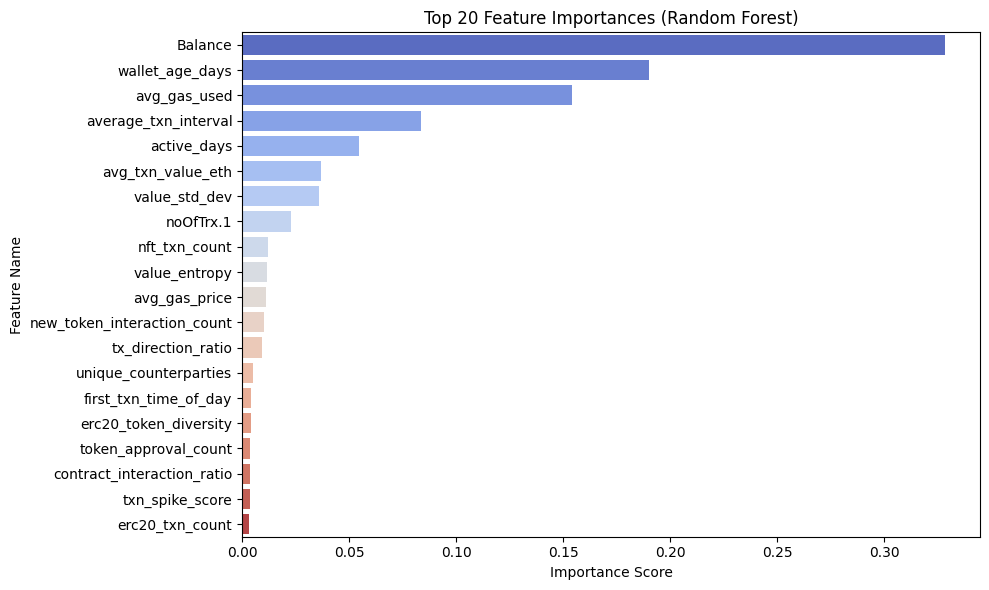

In [5]:
# -------- 3. Model-Based Feature Importance (Random Forest) --------
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_corr_filtered, y)
importances = pd.Series(rf.feature_importances_, index=X_corr_filtered.columns)
top_20_features = importances.sort_values(ascending=False).head(20)

# Plot top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_features.values, y=top_20_features.index, palette='coolwarm')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

In [6]:
# -------- 4. Reduced Feature Set --------
X_selected = X_corr_filtered[top_20_features.index]
print("✅ Final features selected:", list(X_selected.columns))

✅ Final features selected: ['Balance', 'wallet_age_days', 'avg_gas_used', 'average_txn_interval', 'active_days', 'avg_txn_value_eth', 'value_std_dev', 'noOfTrx.1', 'nft_txn_count', 'value_entropy', 'avg_gas_price', 'new_token_interaction_count', 'tx_direction_ratio', 'unique_counterparties', 'first_txn_time_of_day', 'erc20_token_diversity', 'token_approval_count', 'contract_interaction_ratio', 'txn_spike_score', 'erc20_txn_count']


## MODEL

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

## Classification with Selected Features

In [8]:
# Define selected feature set
X_selected = X_corr_filtered[top_20_features.index]
y_selected = y

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, stratify=y_selected, random_state=42)

## Train a Classifier (Random Forest)

In [9]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # Probability for positive class

## Evaluation Metrics & Classification Report

In [10]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93      1563
           1       0.98      0.97      0.98      5187

    accuracy                           0.96      6750
   macro avg       0.94      0.96      0.95      6750
weighted avg       0.97      0.96      0.96      6750

Confusion Matrix:
 [[1485   78]
 [ 162 5025]]
ROC-AUC Score: 0.9910326902447318


## Plot ROC Curve

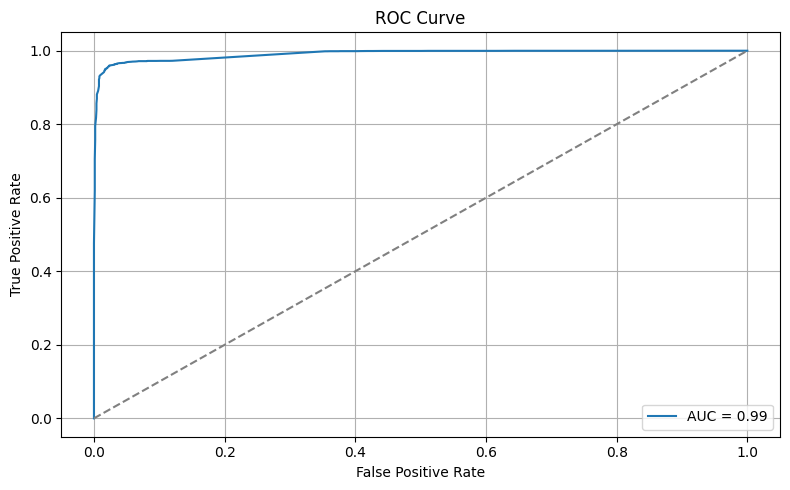

In [11]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Generate Trust Scores from Classifier

In [12]:
# Trust score as scaled probability
df_test = X_test.copy()
df_test["true_label"] = y_test
df_test["trust_score"] = (y_prob * 100).round(2)

df_test[["trust_score", "true_label"]].head(10)


,trust_score,true_label
27448,100.0,1
29789,100.0,1
33704,10.0,0
17919,1.0,0
27740,94.0,1
17556,100.0,1
8950,79.0,1
11411,100.0,1
7112,89.0,1
5850,89.0,1


# MULTIPLE MODELS

🔍 Missing values before filling:
Balance                        285
noOfTrx.1                        0
token_approval_count             0
new_token_interaction_count      0
average_txn_interval             0
tx_burst_count                   0
value_entropy                    0
contract_interaction_ratio       0
tx_direction_ratio               0
erc20_token_diversity            0
dtype: int64
🔍 Total wallets with 0 or missing balance: 285


,Address,Balance,isSafe
19016,0x7fa0ecbd6a4531e431b24814da71b9a483f85ff4,NaN,False
19017,0x00d748563106e9de57de568ab5e00d60e1ce82b9,NaN,True
19018,0x7b9a006ba1a7a63d2c985922165518cdf6f571bc,NaN,True
19019,0x2b4a53413ead54a8ab7b11691c36bf1b07225aad,NaN,True
19020,0x9492510bbcb93b6992d8b7bb67888558e12dcac4,NaN,True
19021,0x5649b4dd00780e99bab7abb4a3d581ea1aeb23d0,NaN,True
19022,0x3e2bf2822a6086ac0cca35f52714b953f2436f29,NaN,True
19023,0x813f45bd0b48a334a3cc06bcef1c44aad907b8c1,NaN,True
19024,0x912b91c05ec3a7dd90b78f49e6666f45ec569664,NaN,True
19025,0x9631200833a348641c5d08c5e146bbbfcd5367d2,NaN,True


✅ Missing values filled using column medians.


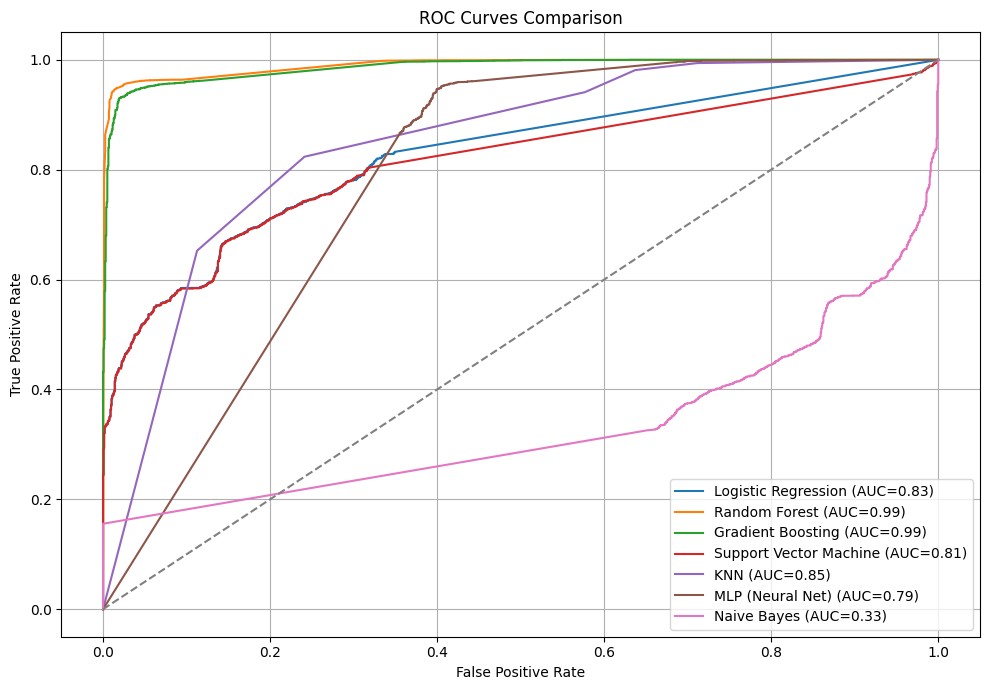

🔍 Model Evaluation Summary:


,Model,Accuracy,F1-Score,ROC-AUC
1,Random Forest,0.9596,0.9734,0.9900
2,Gradient Boosting,0.9501,0.9671,0.9861
4,KNN,0.8212,0.8900,0.8468
0,Logistic Regression,0.7684,0.8691,0.8257
3,Support Vector Machine,0.7684,0.8691,0.8125
5,MLP (Neural Net),0.8699,0.9188,0.7866
6,Naive Bayes,0.2381,0.0168,0.3308


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# ----------------------- Load and Prepare -----------------------

df = pd.read_csv('combined_wallets_with_transactions_and_balances_3.csv')

non_feature_cols = ['Address', 'Name', 'Tags', 'Transactions', 'approved_token_list', 'isSafe']
target_col = 'isSafe'

feature_df = df.drop(columns=non_feature_cols, errors='ignore')
X = feature_df
y = df[target_col].astype(int)

# Optional: Feature Selection from your previous RF step
# Assuming top_20_features already defined
# X = X[top_20_features.index]

# Fill missing values BEFORE train-test split

# Optional: check how many missing values you have
print("🔍 Missing values before filling:")
print(X.isna().sum().sort_values(ascending=False).head(10))
zero_fill_cols = ['Balance', 'noOfTrx.1', 'token_approval_count', 'new_token_interaction_count', 
                  'erc20_token_diversity', 'erc20_txn_count', 'nft_txn_count', 'sbt_poap_event_count']
zero_balance_rows = df[(df['Balance'].isna()) | (df['Balance'] == 0)]
print(f"🔍 Total wallets with 0 or missing balance: {len(zero_balance_rows)}")
display(zero_balance_rows[['Address', 'Balance', 'isSafe']].head(10))  # Display first 10 rows
X[zero_fill_cols] = X[zero_fill_cols].fillna(0)

# Fill NaNs with median of each column
X = X.fillna(X.median(numeric_only=True))

print("✅ Missing values filled using column medians.")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train-test split
# ----------------------- Define Models -----------------------

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42),
    "Naive Bayes": GaussianNB()
}


# ----------------------- Train and Evaluate -----------------------

results = []

plt.figure(figsize=(10, 7))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'F1-Score': round(f1, 4),
        'ROC-AUC': round(roc, 4)
    })

    plt.plot(fpr, tpr, label=f"{name} (AUC={roc:.2f})")

# Plot ROC Curves
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curves Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------- Show Summary -----------------------

results_df = pd.DataFrame(results).sort_values(by='ROC-AUC', ascending=False)
print("🔍 Model Evaluation Summary:")
display(results_df)


In [14]:
X

,noOfTrx.1,Balance,total_transactions,self_transfer_ratio,circular_txn_count,circular_txn_ratio,avg_txn_value_eth,txn_spike_score,value_std_dev,avg_gas_used,...,first_txn_time_of_day,erc20_token_diversity,tx_direction_ratio,contract_interaction_ratio,value_entropy,tx_burst_count,average_txn_interval,new_token_interaction_count,token_approval_count,sbt_poap_event_count
0,19,83021670189587,0.0019,0.000000,0.000000,0.000000,4.567496e-05,0.000805,0.000039,0.001458,...,0.304348,0.000000,0.000212,0.0000,0.319688,0.000805,0.047155,0.0004,0.000000,0.000000
1,139,89999706252309863072,0.0139,0.000000,0.000000,0.000000,3.616925e-05,0.000805,0.000054,0.001481,...,0.869565,0.001381,0.000405,0.0000,0.363128,0.000805,0.007271,0.0021,0.000000,0.000000
2,10000,0,1.0000,0.000000,0.000000,0.000000,6.363344e-07,0.002415,0.000011,0.007678,...,0.260870,0.000000,0.000053,0.0001,0.002187,0.002415,0.000002,0.0002,0.000000,0.000000
3,3,2757182116120516,0.0003,0.000000,0.000000,0.000000,3.425027e-04,0.000805,0.000152,0.001458,...,0.000000,0.000000,0.000106,0.0000,0.119280,0.000805,0.137288,0.0002,0.000000,0.000000
4,28,54715310931929644663,0.0028,0.000000,0.000404,0.144315,7.556232e-05,0.001610,0.000108,0.003572,...,1.000000,0.001381,0.000451,0.0000,0.272329,0.001610,0.016256,0.0017,0.000236,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33744,242,34181892106133550041,0.0242,0.004132,0.001313,0.054267,1.920657e-06,0.001610,0.000003,0.002695,...,0.000000,0.040055,0.000275,0.0000,0.277794,0.001610,0.003827,0.0070,0.000118,0.000000
33745,58,11118367256799,0.0058,0.000000,0.000101,0.017417,9.319649e-06,0.001610,0.000013,0.001460,...,1.000000,0.000691,0.000142,0.0000,0.411332,0.001610,0.010204,0.0014,0.000000,0.000000
33746,54,22714410955797866645,0.0054,0.018519,0.000000,0.000000,1.985651e-05,0.000805,0.000022,0.001649,...,0.173913,0.001381,0.000283,0.0000,0.362849,0.000805,0.016160,0.0012,0.000118,0.000000
33747,0,0,0.0000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score

# Use top performing model (e.g., Random Forest)
base_model = RandomForestClassifier(random_state=42)

# Basic hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(base_model, param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("✅ Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


# Calibrate model with Platt scaling (sigmoid) on validation
calibrated_clf = CalibratedClassifierCV(best_model, method='sigmoid', cv=5)
calibrated_clf.fit(X_train, y_train)


# Fit on all data (optional if you want to maximize training data)
calibrated_clf.fit(X, y)

# Get trust scores (0–100) from calibrated probabilities
trust_scores = calibrated_clf.predict_proba(X)[:, 1] * 100
df['trust_score'] = trust_scores.round(2)

# Save or inspect trust scores
display(df[['Address', 'trust_score', 'isSafe']].head(10))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
✅ Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


,Address,trust_score,isSafe
0,0xf6937f486fbc7dcb0a2c689e34d1dedf20b58731,99.45,True
1,0xf4618a00ed016475ae4033bfff78946fec712f3b,99.45,True
2,0x0c3de458b51a11da7d4616f42f66c861e3859d3e,99.43,True
3,0x7b86d0136fb2a90bec18e92046c8400f2f4ab5f4,99.45,True
4,0x5d234535f2283c8e48a05ad9b7994077bdc743ab,99.47,True
5,0xde05dcb77aff940dd524c056e4219786114e37c4,99.45,True
6,0x24b1d27b0f6b5a2aa052acf59817a8d9e7a8600a,98.88,True
7,0x50fb734f0448a122b102f9a211e52c2f14eb208a,99.43,True
8,0x886fc23811240f94e32fa66c748277f8f1b4a805,99.47,True
9,0x93737345d0395976751329feff0fb84fb13d58ec,99.27,True


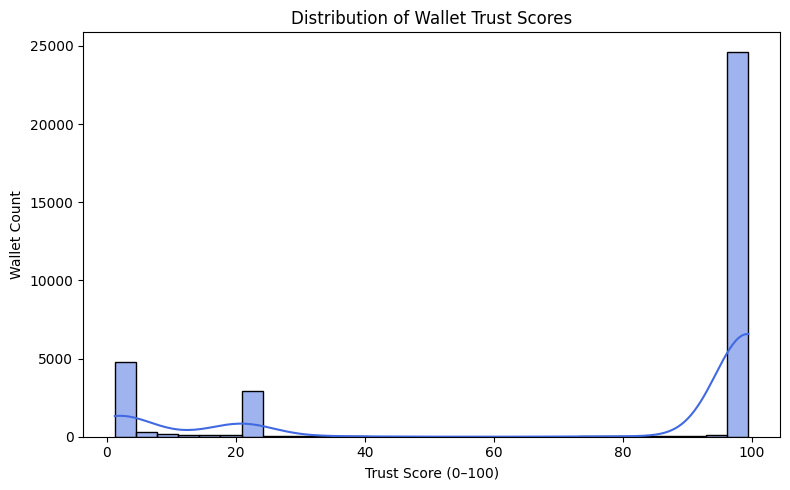

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(df['trust_score'], bins=30, kde=True, color='royalblue')
plt.title("Distribution of Wallet Trust Scores")
plt.xlabel("Trust Score (0–100)")
plt.ylabel("Wallet Count")
plt.tight_layout()
plt.show()


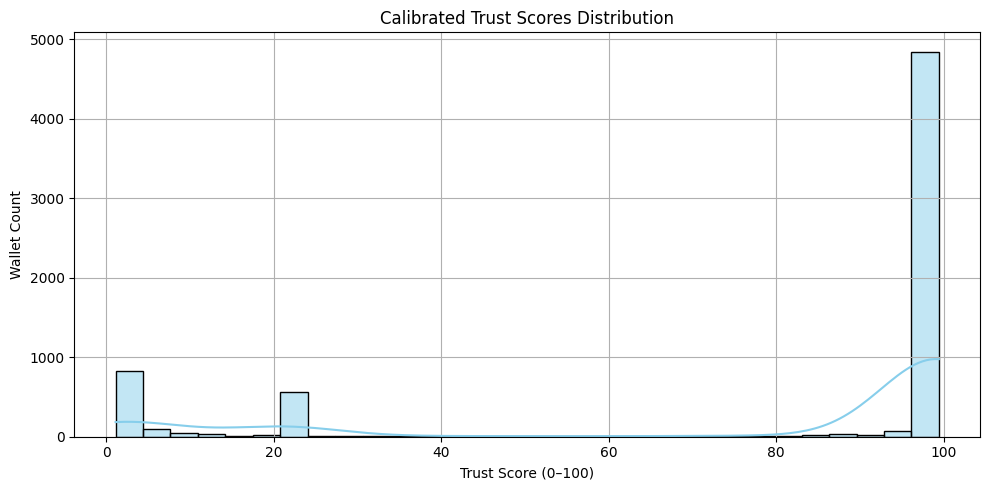

🔍 Calibrated RF ROC-AUC: 0.9897333026942079
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      1563
           1       0.98      0.96      0.97      5187

    accuracy                           0.96      6750
   macro avg       0.93      0.95      0.94      6750
weighted avg       0.96      0.96      0.96      6750



In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# --- Base Classifier
base_rf = RandomForestClassifier(n_estimators=100, random_state=42)
calibrated_rf = CalibratedClassifierCV(base_rf, cv=5)

# --- Train & Predict
calibrated_rf.fit(X_train, y_train)
y_prob = calibrated_rf.predict_proba(X_test)[:, 1]

# --- Create Trust Score
trust_score_calibrated = (y_prob * 100).round(2)

# --- Plot Distribution
plt.figure(figsize=(10, 5))
sns.histplot(trust_score_calibrated, bins=30, kde=True, color='skyblue')
plt.title("Calibrated Trust Scores Distribution")
plt.xlabel("Trust Score (0–100)")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Optional: Print classification report
y_pred = calibrated_rf.predict(X_test)
print("🔍 Calibrated RF ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Classification Report:\n", classification_report(y_test, y_pred))


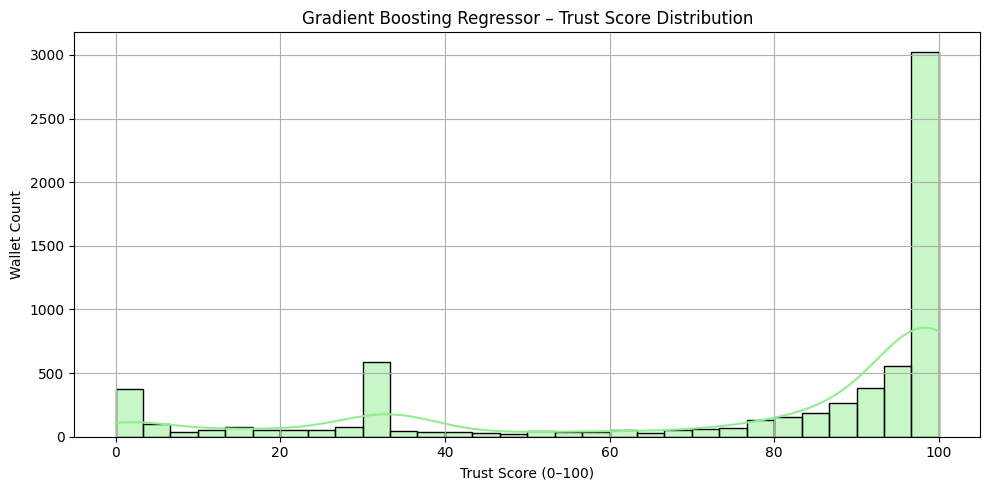

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

# Treat labels as floats for regression
y_reg = y.astype(float)

# --- Train/test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, stratify=y, random_state=42)

# --- Train Regressor
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gbr.fit(X_train_r, y_train_r)

# --- Predict Trust Scores (0–100)
trust_scores_regressor = (gbr.predict(X_test_r) * 100).clip(0, 100).round(2)

# --- Plot Distribution
plt.figure(figsize=(10, 5))
sns.histplot(trust_scores_regressor, bins=30, kde=True, color='lightgreen')
plt.title("Gradient Boosting Regressor – Trust Score Distribution")
plt.xlabel("Trust Score (0–100)")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.tight_layout()
plt.show()


## UNSUPERVISED

#### KMeans Clustering

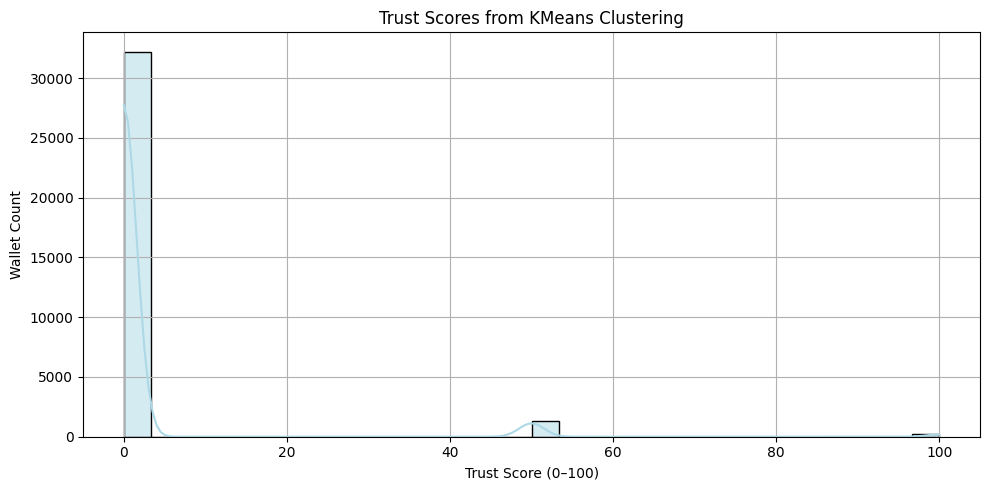

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Try 3 clusters (unsafe, suspicious, safe)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add scores: map cluster to 0–100 based on centroid distance to 'safe'
cluster_scores = {i: int((i / (kmeans.n_clusters - 1)) * 100) for i in sorted(np.argsort(kmeans.cluster_centers_[:, 0]))}
trust_scores_kmeans = pd.Series(clusters).map(cluster_scores)

# Plot KMeans Distribution
plt.figure(figsize=(10, 5))
sns.histplot(trust_scores_kmeans, bins=30, kde=True, color='lightblue')
plt.title("Trust Scores from KMeans Clustering")
plt.xlabel("Trust Score (0–100)")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.tight_layout()
plt.show()


#### DBSCAN – Density-based clustering

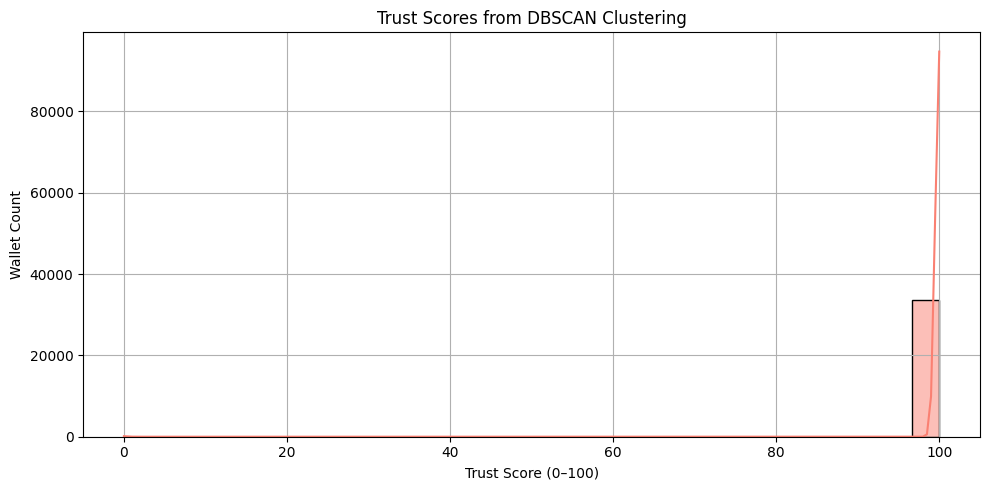

In [20]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Reduce for DBSCAN
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

dbscan = DBSCAN(eps=1.5, min_samples=10)
db_labels = dbscan.fit_predict(X_pca)

# Assign trust scores: noise (-1) = 0, clusters get increasing scores
unique_clusters = sorted(set(db_labels))
trust_scores_dbscan = pd.Series([int((unique_clusters.index(c) / (len(unique_clusters) - 1)) * 100) if c != -1 else 0 for c in db_labels])

# Plot DBSCAN Results
plt.figure(figsize=(10, 5))
sns.histplot(trust_scores_dbscan, bins=30, kde=True, color='salmon')
plt.title("Trust Scores from DBSCAN Clustering")
plt.xlabel("Trust Score (0–100)")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Isolation Forest – Anomaly Detection

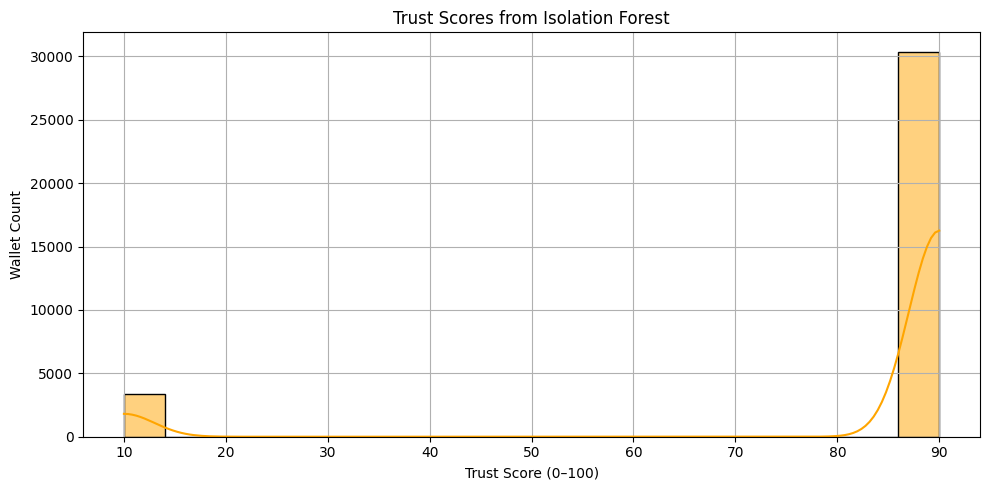

In [21]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.1, random_state=42)
labels_iso = iso.fit_predict(X_scaled)

# Trust score: normal = high, anomaly = low
trust_scores_iso = pd.Series([90 if l == 1 else 10 for l in labels_iso])

plt.figure(figsize=(10, 5))
sns.histplot(trust_scores_iso, bins=20, kde=True, color='orange')
plt.title("Trust Scores from Isolation Forest")
plt.xlabel("Trust Score (0–100)")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.tight_layout()
plt.show()


## FINAL MODEL

Fitting 3 folds for each of 1 candidates, totalling 3 fits
✅ Best Hyperparameters:
{'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 500, 'subsample': 0.8}

📉 Best Negative MSE Score: 0.9876453070059567


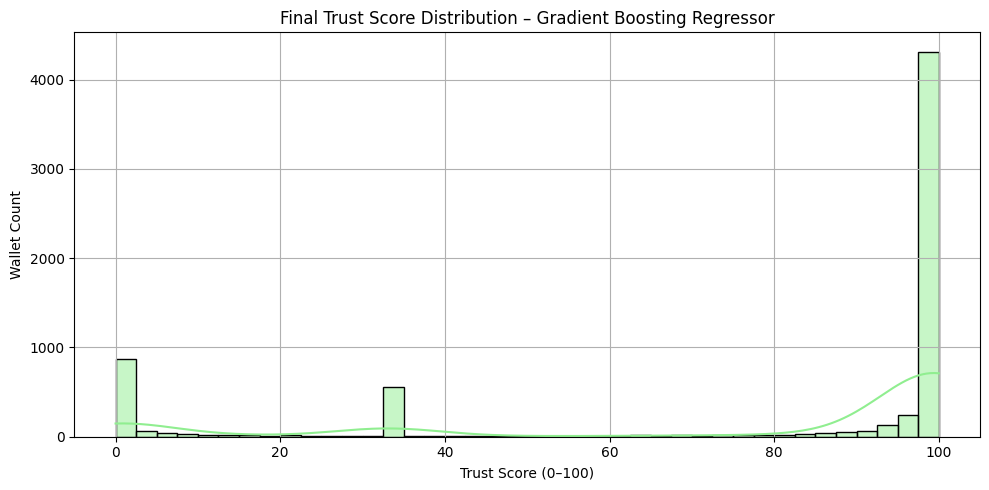

MSE: 316.7379729481482
MAE: 6.696480000000001
R² Score: 0.8219948970258957
Accuracy: 0.9543703703703704
F1 Score: 0.9696491919590067
ROC-AUC: 0.9883987615576665


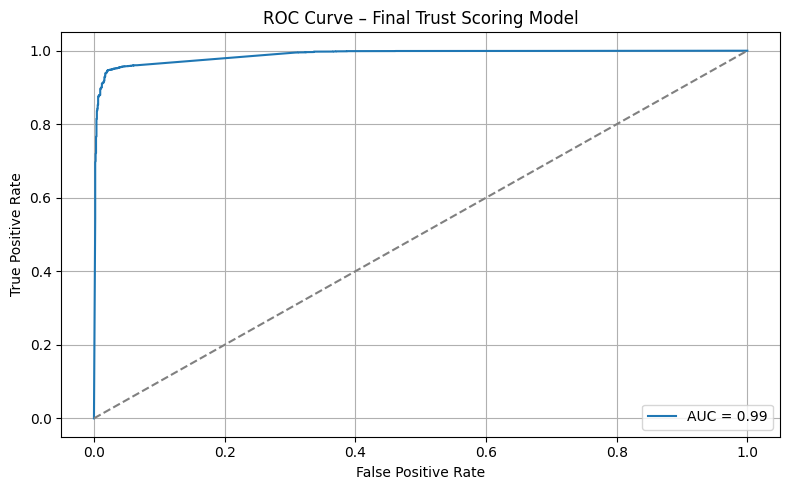

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler

X['Address'] = df['Address']  # add it before splitting
addresses = X['Address']  # save for reference
X = X.drop(columns=['Address'])  # remove before scaling/splitting


scaler = MinMaxScaler()
X[['Balance', 'noOfTrx.1', 'avg_txn_value_eth', 'value_std_dev']] = scaler.fit_transform(
    X[['Balance', 'noOfTrx.1', 'avg_txn_value_eth', 'value_std_dev']]
)

# -------------------- Treat as Regression --------------------
y_reg = y.astype(float)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, stratify=y, random_state=42)


# -------------------- Final Model (Aligned with Fast Version) --------------------
# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [3, 5, 10],
#     'learning_rate': [0.05, 0.1],
#     'subsample': [0.8, 1.0],
#     'min_samples_split': [2, 5]
# }

param_grid = {
    'n_estimators': [500],
    'max_depth': [10],
    'learning_rate': [0.05],
    'subsample': [0.8],
    'min_samples_split': [5]
}

# {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 500, 'subsample': 0.8}

# Initialize the model
gbr = GradientBoostingRegressor(random_state=42)

# Grid search with 3-fold cross-validation
grid = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1  # Use all CPU cores
)

grid.fit(X_train_r, y_train_r)

best_model = grid.best_estimator_

print("✅ Best Hyperparameters:")
print(grid.best_params_)

print("\n📉 Best Negative MSE Score:", grid_search.best_score_)

# -------------------- Predict Trust Score (0–100 scale) --------------------
trust_scores = (best_model.predict(X_test_r) * 100).clip(0, 100).round(2)

# -------------------- Plot Distribution --------------------
plt.figure(figsize=(10, 5))
sns.histplot(trust_scores, bins=40, kde=True, color='lightgreen')
plt.title("Final Trust Score Distribution – Gradient Boosting Regressor")
plt.xlabel("Trust Score (0–100)")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------- Evaluate Regression --------------------
print("MSE:", mean_squared_error(y_test_r * 100, trust_scores))
print("MAE:", mean_absolute_error(y_test_r * 100, trust_scores))
print("R² Score:", r2_score(y_test_r * 100, trust_scores))

# -------------------- Binarize for ROC & F1 (70 as threshold) --------------------
y_true_bin = (y_test_r >= 0.7).astype(int)
y_pred_bin = (trust_scores >= 70).astype(int)

print("Accuracy:", accuracy_score(y_true_bin, y_pred_bin))
print("F1 Score:", f1_score(y_true_bin, y_pred_bin))
print("ROC-AUC:", roc_auc_score(y_true_bin, trust_scores))

# -------------------- ROC Curve --------------------
fpr, tpr, _ = roc_curve(y_true_bin, trust_scores)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true_bin, trust_scores):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Final Trust Scoring Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
test_addresses = addresses.loc[X_test_r.index]

df_test_scores = X_test_r.copy()
df_test_scores['trust_score'] = trust_scores
df_test_scores['isSafe'] = df_test_scores['trust_score'] >= 70
df_test_scores['Address'] = test_addresses

df_test_scores[['Address', 'trust_score', 'isSafe']].to_csv("test_wallet_trust_scores.csv", index=False)
display(df_test_scores[['Address', 'trust_score', 'isSafe']])

,Address,trust_score,isSafe
27448,0x044586cb67d18e936fed20a6224f8dd64c5c3d23,100.00,True
29789,0xdda028299cd138e4cf17b57d63fd0ad362231385,100.00,True
33704,0x58ea1c0616d6356c82d0282d220fe9f9b7706796,0.00,False
17919,0xadf363c6090f911f20c1b59a99928bcb5eed0e5c,0.00,False
27740,0xcf123a8210cf21fb755d4faa0ea737f7ce3adefd,99.72,True
...,...,...,...
6370,0x0000000000000000000000000000000000000004,71.69,True
8977,0x3ea8b081806a189cbc8ddc345bb184b813924ae8,99.51,True
24407,0xbf6aced8fe4477622a7f0cba6810adb711a1c9b5,98.42,True
32607,0xccc140ca258e9a30e7f625ccd8e8914f924b8149,99.25,True


In [24]:
X_train_r

,noOfTrx.1,Balance,total_transactions,self_transfer_ratio,circular_txn_count,circular_txn_ratio,avg_txn_value_eth,txn_spike_score,value_std_dev,avg_gas_used,...,first_txn_time_of_day,erc20_token_diversity,tx_direction_ratio,contract_interaction_ratio,value_entropy,tx_burst_count,average_txn_interval,new_token_interaction_count,token_approval_count,sbt_poap_event_count
22454,0.0003,2.120562e-12,0.0003,0.000000,0.000101,0.336734,1.611200e-08,0.000805,7.506127e-09,0.003744,...,0.304348,0.000000,0.000212,0.000000,0.119280,0.000805,1.904334e-07,0.0003,0.000000,0.0
25605,0.0003,8.825259e-13,0.0003,0.000000,0.000000,0.000000,1.185959e-03,0.000805,2.647207e-04,0.001458,...,0.217391,0.000000,0.000106,0.000000,0.119280,0.000805,2.145099e-01,0.0002,0.000000,0.0
8359,0.0007,3.023690e-04,0.0007,0.000000,0.000000,0.000000,8.489566e-04,0.000805,5.812005e-04,0.002850,...,0.739130,0.000000,0.000071,0.000000,0.211275,0.000805,1.355766e-01,0.0002,0.000000,0.0
18852,0.0031,0.000000e+00,0.0031,0.000000,0.000000,0.000000,4.260085e-06,0.000805,3.989517e-06,0.001458,...,0.000000,0.000000,0.000034,0.000000,0.320622,0.000805,7.745707e-05,0.0004,0.000000,0.0
23171,0.1899,0.000000e+00,0.1899,0.000000,0.000000,0.000000,2.173674e-07,0.006441,4.228253e-07,0.012335,...,1.000000,0.000000,0.000006,0.000527,0.336095,0.006441,4.640186e-05,0.0002,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11498,0.6934,8.404650e-07,0.6934,0.000000,0.000000,0.000000,5.978976e-09,0.001610,1.838906e-07,0.003999,...,0.956522,0.000691,0.000053,0.000000,0.001233,0.001610,1.737073e-05,0.0002,0.000000,0.0
32691,0.0000,0.000000e+00,0.0000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0000,0.000000,0.0
9667,0.0013,3.739633e-07,0.0013,0.076923,0.000000,0.000000,9.021202e-02,0.000805,9.995563e-02,0.026728,...,0.565217,0.000000,0.000212,0.000000,0.220595,0.000805,5.063681e-02,0.0005,0.000000,0.0
23740,0.0025,1.953838e-05,0.0025,0.000000,0.000101,0.040408,3.112317e-05,0.000805,2.866499e-05,0.001597,...,0.826087,0.000000,0.000265,0.000000,0.331423,0.000805,1.706410e-02,0.0005,0.000000,0.0


In [25]:
import sys
!{sys.executable} -m pip install shap


[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python3 -m pip install --upgrade pip


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 6721/6750 [03:25<00:00]        

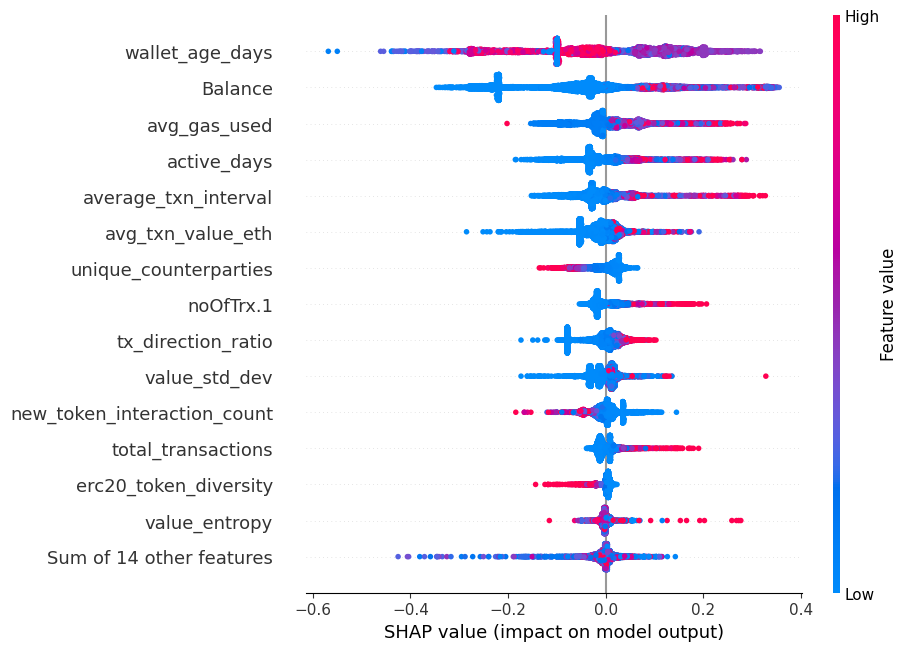

In [26]:
import shap
explainer = shap.Explainer(best_model, X_train_r)
shap_values = explainer(X_test_r, check_additivity=False)

shap.plots.beeswarm(shap_values, max_display=15)


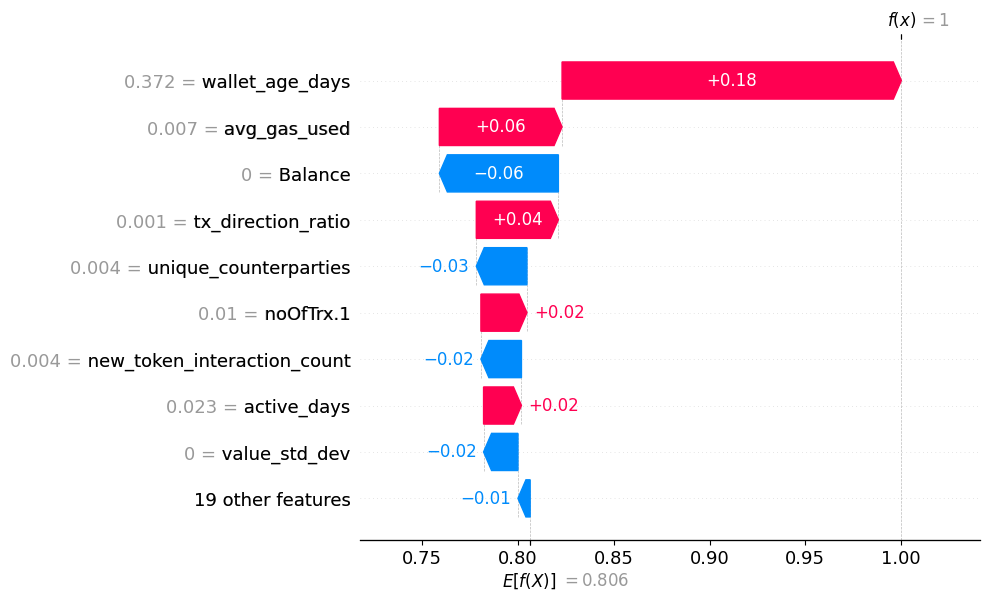

In [27]:
shap.plots.waterfall(shap_values[0])

In [28]:
X_train_r

,noOfTrx.1,Balance,total_transactions,self_transfer_ratio,circular_txn_count,circular_txn_ratio,avg_txn_value_eth,txn_spike_score,value_std_dev,avg_gas_used,...,first_txn_time_of_day,erc20_token_diversity,tx_direction_ratio,contract_interaction_ratio,value_entropy,tx_burst_count,average_txn_interval,new_token_interaction_count,token_approval_count,sbt_poap_event_count
22454,0.0003,2.120562e-12,0.0003,0.000000,0.000101,0.336734,1.611200e-08,0.000805,7.506127e-09,0.003744,...,0.304348,0.000000,0.000212,0.000000,0.119280,0.000805,1.904334e-07,0.0003,0.000000,0.0
25605,0.0003,8.825259e-13,0.0003,0.000000,0.000000,0.000000,1.185959e-03,0.000805,2.647207e-04,0.001458,...,0.217391,0.000000,0.000106,0.000000,0.119280,0.000805,2.145099e-01,0.0002,0.000000,0.0
8359,0.0007,3.023690e-04,0.0007,0.000000,0.000000,0.000000,8.489566e-04,0.000805,5.812005e-04,0.002850,...,0.739130,0.000000,0.000071,0.000000,0.211275,0.000805,1.355766e-01,0.0002,0.000000,0.0
18852,0.0031,0.000000e+00,0.0031,0.000000,0.000000,0.000000,4.260085e-06,0.000805,3.989517e-06,0.001458,...,0.000000,0.000000,0.000034,0.000000,0.320622,0.000805,7.745707e-05,0.0004,0.000000,0.0
23171,0.1899,0.000000e+00,0.1899,0.000000,0.000000,0.000000,2.173674e-07,0.006441,4.228253e-07,0.012335,...,1.000000,0.000000,0.000006,0.000527,0.336095,0.006441,4.640186e-05,0.0002,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11498,0.6934,8.404650e-07,0.6934,0.000000,0.000000,0.000000,5.978976e-09,0.001610,1.838906e-07,0.003999,...,0.956522,0.000691,0.000053,0.000000,0.001233,0.001610,1.737073e-05,0.0002,0.000000,0.0
32691,0.0000,0.000000e+00,0.0000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0000,0.000000,0.0
9667,0.0013,3.739633e-07,0.0013,0.076923,0.000000,0.000000,9.021202e-02,0.000805,9.995563e-02,0.026728,...,0.565217,0.000000,0.000212,0.000000,0.220595,0.000805,5.063681e-02,0.0005,0.000000,0.0
23740,0.0025,1.953838e-05,0.0025,0.000000,0.000101,0.040408,3.112317e-05,0.000805,2.866499e-05,0.001597,...,0.826087,0.000000,0.000265,0.000000,0.331423,0.000805,1.706410e-02,0.0005,0.000000,0.0


In [29]:
# from sklearn.preprocessing import QuantileTransformer

# qt = QuantileTransformer(output_distribution='normal')
# y_train_trans = qt.fit_transform(y_train_r.values.reshape(-1, 1)).ravel()

# gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
# gbr.fit(X_train_r, y_train_trans)

# # Inverse transform predictions
# pred_trans = gbr.predict(X_test_r).reshape(-1, 1)
# trust_scores = qt.inverse_transform(pred_trans).ravel() * 100

# from sklearn.ensemble import GradientBoostingRegressor

# gbr_q = GradientBoostingRegressor(loss='quantile', alpha=0.5, random_state=42)
# gbr_q.fit(X_train_r, y_train_r)
# trust_scores_q = (gbr_q.predict(X_test_r) * 100).clip(0, 100)

# plt.figure(figsize=(10, 5))
# sns.histplot(trust_scores, bins=40, kde=True, color='salmon')
# plt.title("Trust Score Distribution – Quantile/Transformed Model")
# plt.xlabel("Trust Score (0–100)")
# plt.ylabel("Wallet Count")
# plt.grid(True)
# plt.tight_layout()
# plt.show()



📊 Confusion Matrix Breakdown:
True Positives (TP): 4920
True Negatives (TN): 1522
False Positives (FP): 41
False Negatives (FN): 267


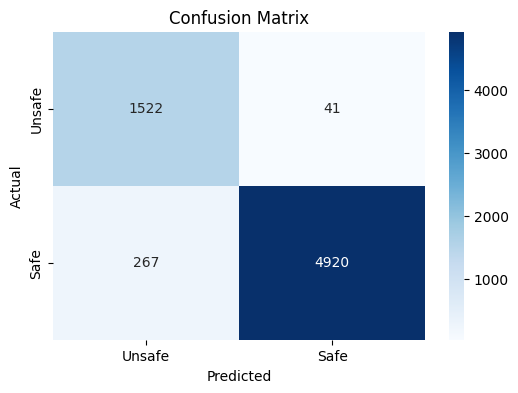


📝 Detailed Classification Report:
              precision    recall  f1-score   support

      Unsafe       0.85      0.97      0.91      1563
        Safe       0.99      0.95      0.97      5187

    accuracy                           0.95      6750
   macro avg       0.92      0.96      0.94      6750
weighted avg       0.96      0.95      0.96      6750



In [30]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true_bin, y_pred_bin)

# Extract values
tn, fp, fn, tp = cm.ravel()

print("\n📊 Confusion Matrix Breakdown:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

# Optional: display as a matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Unsafe', 'Safe'], yticklabels=['Unsafe', 'Safe'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# -------------------- Classification Report --------------------
print("\n📝 Detailed Classification Report:")
print(classification_report(y_true_bin, y_pred_bin, target_names=['Unsafe', 'Safe']))


In [33]:
# Create a DataFrame for analysis
import pandas as pd

# Assuming 'addresses' variable holds the address list from earlier
results_df = pd.DataFrame({
    'Address': addresses.loc[X_test_r.index].values,
    'True_Label': y_true_bin,
    'Predicted_Score': trust_scores,
    'Predicted_Label': y_pred_bin
})

# Filter for wallets with trust score < 20
low_score_wallets = results_df[results_df['Predicted_Score'] < 20].sort_values(by='Predicted_Score')

print("\n📉 Wallets with Trust Score < 20:")
print(low_score_wallets.tail(10))  # Show top 10 for brevity



📉 Wallets with Trust Score < 20:
                                          Address  True_Label  \
5828   0xefc534c47d753f94944b734d2c546cb1fba8904e           1   
14723  0x727b6866bdba3921bda2757c42956a02c71f8d7e           0   
9043   0xad54edbe26782a7c190eabc0b35869b0e66ffcce           1   
5565   0x73f2bea72fe860813d8435cd176cfba721deec42           0   
32022  0x37E1AEF441c5B85a4361341cEDc812fd06Cf4A66           0   
23049  0x98f32f86c831b54bf3f5bbc15e4132940ea3b950           1   
32849  0x5b409bf5976adbcbcaf3891d7e7133ce38ba6396           0   
20929  0xb052fe6a594cc9f1e87dcad83cc478f56f0d24b1           0   
30746  0xbc0304b4f1541028580623e323b9218e0d2c6414           0   
30676  0x4ee9241df92e175368fb35dffbab39a82c90d8a9           0   

       Predicted_Score  Predicted_Label  
5828             18.07                0  
14723            18.73                0  
9043             18.84                0  
5565             18.91                0  
32022            19.17                0 

In [ ]:
import pickle
import joblib

with open("../../models/trust_score_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
print("✅ Model saved to trust_score_model.pkl")

joblib.dump(scaler, "../../models/trust_score_scaler.pkl")


✅ Model saved to trust_score_model.pkl


['trust_score_scaler.pkl']